# Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
import io

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.text import tokenizer_from_json

from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Read Dataset

In [3]:
file_name = f'/content/gdrive/MyDrive/Kuliah/Semester 7/AI/UAS/Dataset/labelled-detikcom-reviews-2023-01-31.csv'
dataset = pd.read_csv(file_name)
dataset.head()

,userName,content,sentiment
0,Alamul Alamul,berita,neutral
1,Cucuk Furianto,mantap,positive
2,Benny Wicaksono,selalu yg terdepan terupdate indonesia sy pen...,neutral
3,Admin Sadulur,siplaj,neutral
4,Aji Brewok,mantap berita nya lugas detil,positive


# Data Selection

In [4]:
dataset.drop('userName', axis=1, inplace=True)
dataset.head()

,content,sentiment
0,berita,neutral
1,mantap,positive
2,selalu yg terdepan terupdate indonesia sy pen...,neutral
3,siplaj,neutral
4,mantap berita nya lugas detil,positive


In [5]:
list_sentiment = dataset['sentiment'].to_list()
sentiment_positive = len([i for i in list_sentiment if i == 'positive'])
sentiment_neutral = len([i for i in list_sentiment if i == 'neutral'])
sentiment_negative = len([i for i in list_sentiment if i == 'negative'])

print("Jumlah seluruh data: ", len(list_sentiment))
print("JUmlah data dengan label positif: ", sentiment_positive)
print("JUmlah data dengan label negatif: ", sentiment_negative)
print("JUmlah data dengan label netral: ", sentiment_neutral)

Jumlah seluruh data:  36977
JUmlah data dengan label positif:  11379
JUmlah data dengan label negatif:  5631
JUmlah data dengan label netral:  19967


# Covert Label into Numerical Category

In [6]:
dataset['content'] = dataset['content'].astype('str')
dataset['sentiment'] = dataset['sentiment'].replace(['negative', 'neutral', 'positive'], [0, 1, 2])
dataset.head()

,content,sentiment
0,berita,1
1,mantap,2
2,selalu yg terdepan terupdate indonesia sy pen...,1
3,siplaj,1
4,mantap berita nya lugas detil,2


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36977 entries, 0 to 36976
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    36977 non-null  object
 1   sentiment  36977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 577.9+ KB


# Split Dataset

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    dataset['content'].values, dataset['sentiment'].values, test_size=0.2
)

print("Teks ulasan: ", x_train[0])
print("Sentiment: ", y_train[0])

Teks ulasan:  kadang menggigil baca isi beritanya  
Sentiment:  0


In [9]:
train_sentiment_negative = len([i for i in y_train if i == 0])
train_sentiment_neutral = len([i for i in y_train if i == 1])
train_sentiment_positive = len([i for i in y_train if i == 2])

print("Jumlah seluruh data: ", len(y_train))
print("JUmlah sentiment positif pada data training: ", train_sentiment_positive)
print("JUmlah sentiment negatif pada data training: ", train_sentiment_negative)
print("JUmlah sentiment netral pada data training: ", train_sentiment_neutral)

Jumlah seluruh data:  29581
JUmlah sentiment positif pada data training:  9129
JUmlah sentiment negatif pada data training:  4504
JUmlah sentiment netral pada data training:  15948


# Convert String to Integer

In [10]:
max_vocab = 20000000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train)

# check word index
word2id = tokenizer.word_index
vocab_len = len(word2id) # V

print("Jumlah vocab pada dataset: ", vocab_len)

Jumlah vocab pada dataset:  15447


# Convert Train and Test Sentences into Sequences

In [11]:
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

print("Train sequences: ", train_sequences[0])
print("Test sequences: ", test_sequences[0])

Train sequences:  [72, 6457, 13, 43, 3]
Test sequences:  [373, 434, 21, 53, 26, 57, 81]


In [12]:
saved_tokenizer = f'/content/gdrive/MyDrive/Kuliah/Semester 7/AI/UAS/Model/json_tokenizer_v2.json'
tokenizer_json = tokenizer.to_json()
with io.open(saved_tokenizer, 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [13]:
train_padded = pad_sequences(train_sequences)
train_len = train_padded.shape[1] # T

test_padded = pad_sequences(test_sequences, maxlen=train_len)
test_len = test_padded.shape[1]

print("Panjang train sequence: ", train_len)
print("Panjang test sequence: ", test_len)

Panjang train sequence:  89
Panjang test sequence:  89


# Model Architecture

In [14]:
input_layer = Input(shape=(train_len, ))
print(input_layer)
x = Embedding(vocab_len + 1, 20)(input_layer)
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model = Model(input_layer, x)

KerasTensor(type_spec=TensorSpec(shape=(None, 89), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [15]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 89)]              0         
                                                                 
 embedding (Embedding)       (None, 89, 20)            308960    
                                                                 
 lstm (LSTM)                 (None, 89, 15)            2160      
                                                                 
 global_max_pooling1d (Globa  (None, 15)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                512       
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                             

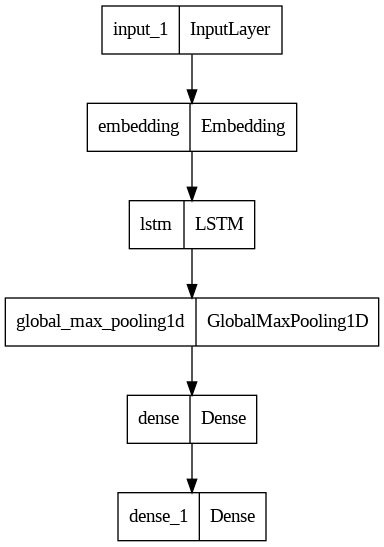

In [16]:
import tensorflow as tf

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

# Implement Callbakcs

In [17]:
class setCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print("\nAccuracy is more than 95% so stop training!")
            self.model.stop_training = True

callbacks = setCallback()

# Training Model

In [18]:
history = model.fit(
    train_padded,
    y_train,
    validation_data=(test_padded, y_test),
    epochs=20,
    callbacks=[callbacks]
)

Epoch 1/20
925/925 [==============================] - 15s 9ms/step - loss: 0.4477 - accuracy: 0.8320 - val_loss: 0.1711 - val_accuracy: 0.9528
Epoch 2/20
919/925 [============================>.] - ETA: 0s - loss: 0.0955 - accuracy: 0.9714
Accuracy is more than 95% so stop training!
925/925 [==============================] - 7s 8ms/step - loss: 0.0954 - accuracy: 0.9714 - val_loss: 0.1192 - val_accuracy: 0.9662


# Evaluation

In [35]:
score = model.evaluate(test_padded, y_test)
print("Model accuracy: ", score[1])

232/232 [==============================] - 1s 5ms/step - loss: 0.1192 - accuracy: 0.9662
Model accuracy:  0.9661979675292969


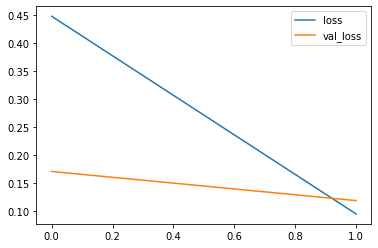

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

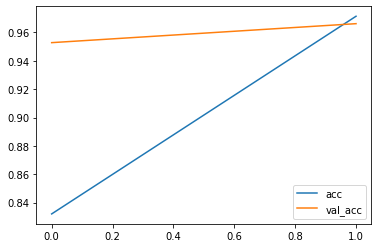

In [37]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

# Model Testing

In [38]:
def predict(text):
    text_sequence = tokenizer.texts_to_sequences(text)
    text_padded = pad_sequences(text_sequence, maxlen=train_len)

    predicted = model.predict(text_padded).round()        

    print(predicted)

    if predicted[0][0] == 1.:
        return "negative"
    elif predicted[0][1] == 1.:
        return "neutral"
    elif predicted[0][2] == 1.:
        return "positif"

text = ['aplkasi ini buruk, bintang 1']
print(predict(text))

1/1 [==============================] - 0s 340ms/step
[[1. 0. 0.]]
negative


# Save the Model

In [39]:
file_name = f'/content/gdrive/MyDrive/Kuliah/Semester 7/AI/UAS/Model/model_v3.h5'
model.save(file_name)

In [40]:
# file_name = f'/content/gdrive/MyDrive/Kuliah/Semester 7/AI/UAS/Model/model_v1.pkl'
from keras.models import load_model
model_path = f'/content/gdrive/MyDrive/Kuliah/Semester 7/AI/UAS/Model/model_v3.h5'
# test_model = pickle.load(open(file_name, 'rb'))
test_model = load_model(model_path)

In [41]:
test_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 89)]              0         
                                                                 
 embedding (Embedding)       (None, 89, 20)            308960    
                                                                 
 lstm (LSTM)                 (None, 89, 15)            2160      
                                                                 
 global_max_pooling1d (Globa  (None, 15)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                512       
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                             

In [42]:
with open('/content/gdrive/MyDrive/Kuliah/Semester 7/AI/UAS/Model/json_tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [43]:
def prediction(text):
    # # tokenizer1 = Tokenizer(num_words=2000000)
    # # tokenizer1.fit_on_texts(text)
    text_sequence = loaded_tokenizer.texts_to_sequences(text)
    text_padded = pad_sequences(text_sequence, maxlen=89)

    predicted = test_model.predict(text_padded).round()        

    print(predicted)

    if predicted[0][0] == 1.:
        return "negative"
    elif predicted[0][1] == 1.:
        return "neutral"
    elif predicted[0][2] == 1.:
        return "positif"

sample1 = ['aplkasi ini buruk, bintang 1']
print(prediction(sample1))

1/1 [==============================] - 0s 320ms/step
[[0. 1. 0.]]
neutral
